# Climate Change Data Analysis

This notebook analyzes global climate change indicators using open data. We will explore trends in global temperature anomalies, CO2 emissions, and sea level rise, and examine the relationships between these variables.

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import os
import numpy as np

plt.style.use('default')
sns.set_theme()

## Download the datasets
We download the latest data for global temperature, CO2 emissions, and sea level rise.

In [12]:
def download_dataset(url, filename):
    if not os.path.exists('data'):
        os.makedirs('data')
    response = requests.get(url)
    if response.status_code == 200:
        with open(filename, 'wb') as f:
            f.write(response.content)
        print(f'Downloaded: {filename}')
    else:
        print(f'Failed to download: {filename}')

download_dataset('https://data.giss.nasa.gov/gistemp/tabledata_v4/GLB.Ts+dSST.txt', 'data/temperature_data.csv')
download_dataset('https://raw.githubusercontent.com/owid/co2-data/master/owid-co2-data.csv', 'data/co2_data.csv')
download_dataset('https://raw.githubusercontent.com/datasets/sea-level-rise/master/data/epa-sea-level.csv', 'data/sea_level_data.csv')

Downloaded: data/temperature_data.csv
Downloaded: data/co2_data.csv
Downloaded: data/sea_level_data.csv


## Preprocessing temperature data
The NASA temperature file is a text file. We extract the year and the J-D column (annual temperature anomaly).

In [13]:
def preprocess_temperature_data(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
    data_start = 0
    for i, line in enumerate(lines):
        if line.strip().startswith('Year'):
            data_start = i
            break
    data_lines = lines[data_start+1:]
    years = []
    temps = []
    for line in data_lines:
        if line.strip() and not line.strip().startswith('Year'):
            parts = line.split()
            if len(parts) >= 14:
                try:
                    year = int(parts[0])
                    temp = float(parts[13]) / 100
                    years.append(year)
                    temps.append(temp)
                except (ValueError, IndexError):
                    continue
    temp_data = pd.DataFrame({'Year': years, 'Temperature': temps})
    return temp_data

temp_data = preprocess_temperature_data('data/temperature_data.csv')
temp_data.head()

,Year,Temperature
0,1880,-0.17
1,1881,-0.09
2,1882,-0.11
3,1883,-0.18
4,1884,-0.28


## Preprocessing CO2 data
We use the OWID dataset, filtering only for global data (country == 'World') and using the 'year' and 'co2' columns.

In [14]:
def preprocess_co2_data(filename):
    data = pd.read_csv(filename)
    data = data[data['country'] == 'World']
    data = data[['year', 'co2']].dropna()
    data = data.rename(columns={'year': 'Year', 'co2': 'CO2_Emissions'})
    return data

co2_data = preprocess_co2_data('data/co2_data.csv')
co2_data.head()

,Year,CO2_Emissions
49295,1750,9.306
49296,1751,9.407
49297,1752,9.505
49298,1753,9.610
49299,1754,9.734


## Preprocessing sea level data
We use the 'Year' and 'CSIRO Adjusted Sea Level' columns from the EPA dataset.

In [15]:
def preprocess_sea_level_data(filename):
    data = pd.read_csv(filename)
    data['CSIRO Adjusted Sea Level'] = pd.to_numeric(data['CSIRO Adjusted Sea Level'], errors='coerce')
    data = data.dropna(subset=['CSIRO Adjusted Sea Level'])
    return data[['Year', 'CSIRO Adjusted Sea Level']].rename(columns={'CSIRO Adjusted Sea Level': 'Sea_Level'})

sea_level_data = preprocess_sea_level_data('data/sea_level_data.csv')
sea_level_data.head()

,Year,Sea_Level
0,1880,0.000000
1,1881,0.220472
2,1882,-0.440945
3,1883,-0.232283
4,1884,0.590551


# Visualizations and analysis

## Global temperature trends
We visualize the global temperature anomaly over time.

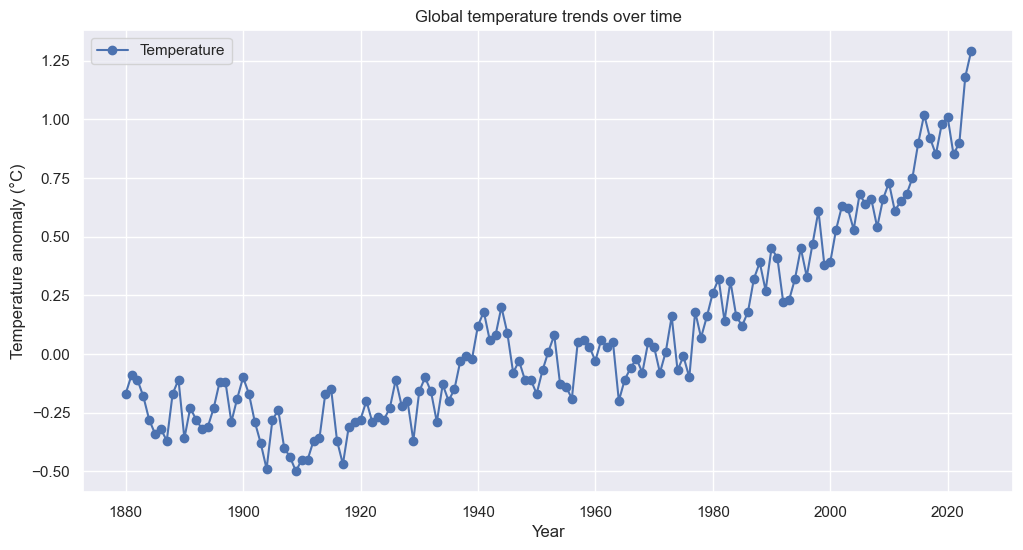

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(temp_data['Year'], temp_data['Temperature'], marker='o', label='Temperature')
plt.title('Global temperature trends over time')
plt.xlabel('Year')
plt.ylabel('Temperature anomaly (°C)')
plt.grid(True)
plt.legend()
plt.show()

**Analysis:**

The graph shows a clear upward trend in global temperature anomalies over the last century, indicating significant global warming, especially in recent decades.

## Global CO2 emissions trends
We visualize the trend of global CO2 emissions.

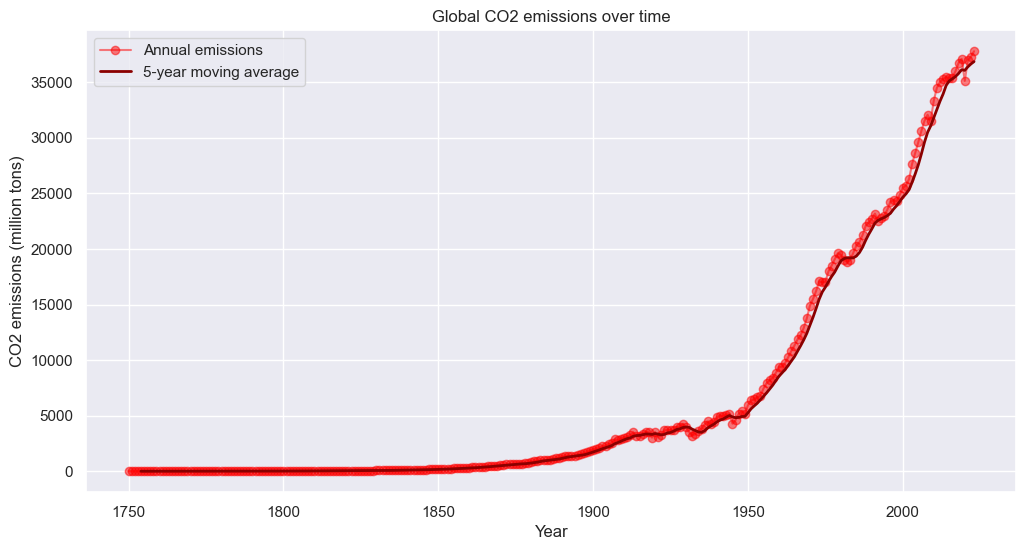

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(co2_data['Year'], co2_data['CO2_Emissions'], marker='o', color='red', alpha=0.5, label='Annual emissions')
rolling_avg = co2_data['CO2_Emissions'].rolling(window=5).mean()
plt.plot(co2_data['Year'], rolling_avg, color='darkred', linewidth=2, label='5-year moving average')
plt.title('Global CO2 emissions over time')
plt.xlabel('Year')
plt.ylabel('CO2 emissions (million tons)')
plt.grid(True)
plt.legend()
plt.show()

**Analysis:**

CO2 emissions have increased dramatically since the mid-20th century, mainly due to industrialization and the use of fossil fuels. This trend is a key factor in global warming.

## Global sea level rise
We examine the trend of global sea level rise.

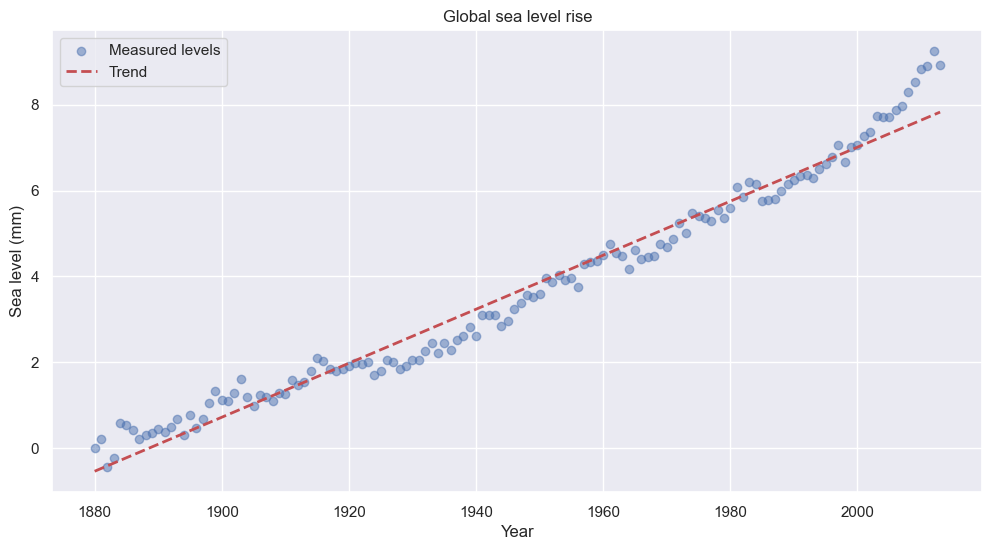

In [18]:
plt.figure(figsize=(12, 6))
plt.scatter(sea_level_data['Year'], sea_level_data['Sea_Level'], alpha=0.5, label='Measured levels')
z = np.polyfit(sea_level_data['Year'], sea_level_data['Sea_Level'], 1)
p = np.poly1d(z)
plt.plot(sea_level_data['Year'], p(sea_level_data['Year']), 'r--', linewidth=2, label='Trend')
plt.title('Global sea level rise')
plt.xlabel('Year')
plt.ylabel('Sea level (mm)')
plt.grid(True)
plt.legend()
plt.show()

**Analysis:**

The data show a steady increase in sea level, consistent with glacier melt and thermal expansion of water due to global warming.

## Correlation between climate indicators
We examine the correlation between temperature, CO2 emissions, and sea level.

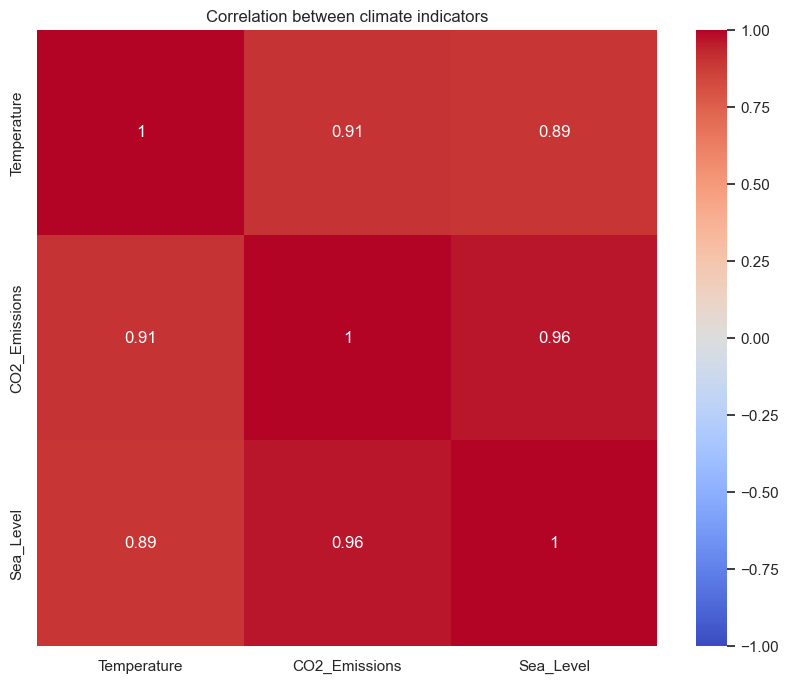

In [19]:
merged_data = pd.merge(temp_data, co2_data, on='Year')
merged_data = pd.merge(merged_data, sea_level_data, on='Year')
corr_matrix = merged_data[['Temperature', 'CO2_Emissions', 'Sea_Level']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation between climate indicators')
plt.show()

**Analysis:**

There is a strong positive correlation between CO2 emissions, temperature anomalies, and sea level rise, supporting the scientific consensus on the impact of greenhouse gases on climate change.

## Combined trends
We visualize all three indicators on the same timeline for a comprehensive view.

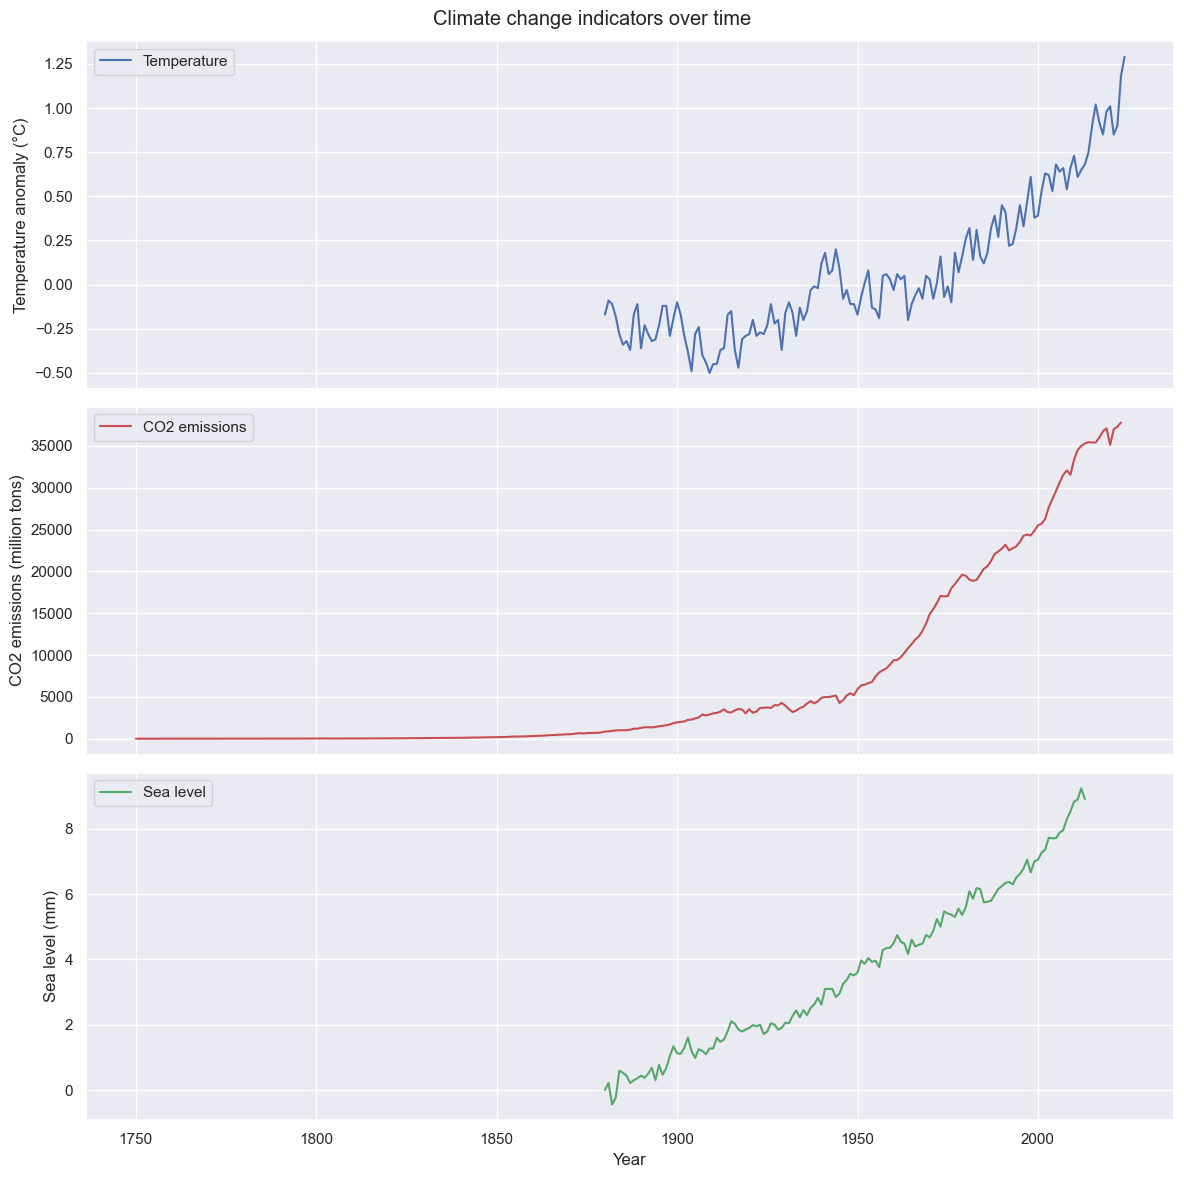

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12), sharex=True)
ax1.plot(temp_data['Year'], temp_data['Temperature'], 'b-', label='Temperature')
ax1.set_ylabel('Temperature anomaly (°C)')
ax1.grid(True)
ax1.legend()
ax2.plot(co2_data['Year'], co2_data['CO2_Emissions'], 'r-', label='CO2 emissions')
ax2.set_ylabel('CO2 emissions (million tons)')
ax2.grid(True)
ax2.legend()
ax3.plot(sea_level_data['Year'], sea_level_data['Sea_Level'], 'g-', label='Sea level')
ax3.set_xlabel('Year')
ax3.set_ylabel('Sea level (mm)')
ax3.grid(True)
ax3.legend()
plt.suptitle('Climate change indicators over time')
plt.tight_layout()
plt.show()

**Analysis:**

This combined view highlights the parallel upward trends in temperature, CO2 emissions, and sea level, illustrating the interconnected nature of climate change indicators.